In [1]:
# Install dependencies
!pip install kaggle
!pip install timm
!pip install opencv-python
!pip install brevitas
!pip install scikit-learn==1.0.2
!pip install imbalanced-learn==0.8.0

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 KB 3.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 KB 5.6 MB/s eta 0:00:00
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 11.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 KB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 KB 20.6 MB/s eta 0:00:00
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 39.8 MB/s eta 0:00:0000:0100:01
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━

In [2]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import brevitas.nn as qnn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
# Set seed for reproducibility
torch.manual_seed(2024)
np.random.seed(2024)

data_dir = "./data/Dataset_BUSI_with_GT"

In [3]:
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    image = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)  # Denoising

    # Apply CLAHE (Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(4, 4))
    image = clahe.apply(image)
    
    # Resize & Normalize
    image = cv2.resize(image, (224, 224))
    image = image / 255.0  # Normalize
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
    
    return image

In [4]:
# Custom Dataset
class BreastUltrasoundDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = preprocess_image(self.image_paths[idx])
        label = self.labels[idx]
        return img, label

In [5]:
# Load Dataset (Strictly Exclude Mask Images)
all_images, all_labels = [], []
class_mapping = {'benign': 0, 'malignant': 1, 'normal': 2}  # Lowercased to match folder names

for class_name, class_idx in class_mapping.items():
    class_folder = os.path.join(data_dir, class_name)
    if os.path.isdir(class_folder):
        for img_file in os.listdir(class_folder):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')) and '_mask' not in img_file.lower():
                all_images.append(os.path.join(class_folder, img_file))
                all_labels.append(0 if class_name == 'normal' else 1)  # Normal (0) vs Cancer (1)

In [6]:
# Print dataset details
print(f"Total images: {len(all_images)}")
print(f"Label distribution: {Counter(all_labels)}")
print(f"Example image paths: {all_images[:3]}")

Total images: 780
Label distribution: Counter({1: 647, 0: 133})
Example image paths: ['./data/Dataset_BUSI_with_GT/benign/benign (418).png', './data/Dataset_BUSI_with_GT/benign/benign (239).png', './data/Dataset_BUSI_with_GT/benign/benign (104).png']


In [7]:
# Oversampling to balance dataset
ros = RandomOverSampler(random_state=2024)
all_images, all_labels = ros.fit_resample(np.array(all_images).reshape(-1, 1), all_labels)
all_images = all_images.flatten().tolist()

In [8]:
# Splitting dataset
train_imgs, test_imgs, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=2024, stratify=all_labels)
train_imgs, val_imgs, train_labels, val_labels = train_test_split(train_imgs, train_labels, test_size=0.2, random_state=2024, stratify=train_labels)

In [9]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),  # Increased rotation range
    transforms.ColorJitter(brightness=0.3, contrast=0.3),  # Adjust contrast & brightness
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15)),  # Slightly increased translate
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),  # Less aggressive crop
    transforms.GaussianBlur(kernel_size=3),  # Simulate ultrasound noise
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [10]:
# Create DataLoaders
batch_size = 32
train_dataset = BreastUltrasoundDataset(train_imgs, train_labels)
val_dataset = BreastUltrasoundDataset(val_imgs, val_labels)
test_dataset = BreastUltrasoundDataset(test_imgs, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

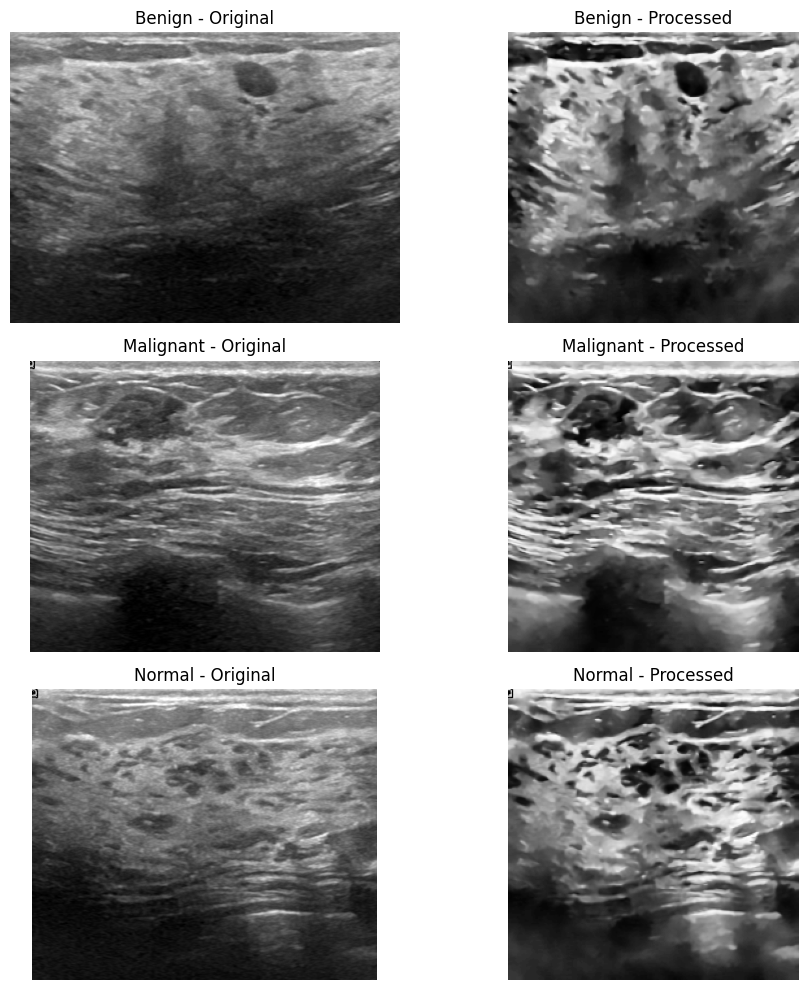

In [11]:
import matplotlib.pyplot as plt

# Function to find sample images from each class
def get_sample_images():
    class_samples = {'benign': None, 'malignant': None, 'normal': None}
    
    for img_path in all_images:
        for class_name in class_samples.keys():
            if class_name in img_path.lower():
                class_samples[class_name] = img_path
                break  # Stop searching once we find a sample for this class
                
        if all(class_samples.values()):  # Stop if we found one sample per class
            break
    
    return class_samples

# Get sample images from each class
sample_images = get_sample_images()

# Plot before and after preprocessing
fig, axes = plt.subplots(3, 2, figsize=(10, 10))  # 3 rows (one per class), 2 columns (before & after)

for i, (class_name, img_path) in enumerate(sample_images.items()):
    if img_path:
        # Load original image
        original_image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Preprocess image
        processed_image = preprocess_image(img_path).squeeze().numpy()

        # Plot original image
        axes[i, 0].imshow(original_image, cmap='gray')
        axes[i, 0].set_title(f"{class_name.capitalize()} - Original")
        axes[i, 0].axis("off")

        # Plot processed image
        axes[i, 1].imshow(processed_image, cmap='gray')
        axes[i, 1].set_title(f"{class_name.capitalize()} - Processed")
        axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import brevitas.nn as qnn  # Importing brevitas for QAT

class QATStage1Model(nn.Module):
    def __init__(self, num_classes=2):
        super(QATStage1Model, self).__init__()

        # Quantized Convolutional layers with Batch Normalization
        self.conv1 = qnn.QuantConv2d(1, 64, kernel_size=3, padding=1, bit_width=8)
        self.bn1 = nn.BatchNorm2d(64)  # Added BatchNorm
        self.conv2 = qnn.QuantConv2d(64, 128, kernel_size=3, padding=1, bit_width=8)
        self.bn2 = nn.BatchNorm2d(128)  # Added BatchNorm

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        self.qrelu = qnn.QuantReLU(bit_width=8)

        # Compute fully connected input size dynamically
        self.fc1_in_features = self._initialize_fc1()

        # Quantized Fully Connected layers
        self.fc1 = qnn.QuantLinear(self.fc1_in_features, 512, bit_width=8, bias=True)
        self.fc2 = qnn.QuantLinear(512, num_classes, bit_width=8, bias=True)

        self.dropout = nn.Dropout(0.4)  # Slightly reduced dropout

    def _initialize_fc1(self):
        """ Compute fc1 input size dynamically """
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 224, 224)  # Adjust based on dataset
            dummy_output = self._forward_convolutions(dummy_input)
            return dummy_output.view(1, -1).size(1)  # Get flattened size

    def _forward_convolutions(self, x):
        """ Forward pass through convolutional layers to compute shape """
        x = self.pool(self.qrelu(self.bn1(self.conv1(x))))
        x = self.pool(self.qrelu(self.bn2(self.conv2(x))))
        return x

    def forward(self, x):
        """ Standard forward pass with QAT layers """
        x = self.pool(self.qrelu(self.bn1(self.conv1(x))))
        x = self.pool(self.qrelu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)  # Flatten dynamically
        x = self.qrelu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Model setup
device = torch.device("cpu")
qat_stage1_model = QATStage1Model(num_classes=2).to(device)
print(qat_stage1_model)

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1255: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1758.)
  return super(Tensor, self).rename(names)


QATStage1Model(
  (conv1): QuantConv2d(
    1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (output_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (weight_quant): WeightQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (tensor_quant): RescalingIntQuant(
        (int_quant): IntQuant(
          (float_to_int_impl): RoundSte()
          (tensor_clamp_impl): TensorClampSte()
          (delay_wrapper): DelayWrapper(
            (delay_impl): _NoDelay()
          )
        )
        (scaling_impl): StatsFromParameterScaling(
          (parameter_list_stats): _ParameterListStats(
            (first_tracked_param): _ViewParameterWrapper(
              (view_shape_impl): OverTensorView()
            )
            (stats): _Stats(
              (stats_impl): AbsMax()
            )
          )
          (stats_scaling_im

In [13]:
import torch
import torch.nn as nn
import torch.optim
import torch.quantization

def train_qat_stage1(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=50, save_path="best_qat_model.pth"):
    model.train()
    model.apply(torch.quantization.enable_observer)  # Enable quantization observers
    model.apply(torch.quantization.enable_fake_quant)  # Enable fake quantization

    best_val_acc = 0.0  # Track the best validation accuracy
    best_model_wts = None  # Store the best model weights

    for epoch in range(epochs):
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()
                _, val_predicted = torch.max(val_outputs, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        val_acc = 100 * val_correct / val_total
        scheduler.step()

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, save_path)
            print(f"Best model saved at epoch {epoch+1} with val acc: {val_acc:.2f}%")

        # Freeze BatchNorm stats after some warm-up epochs (usually after 5-10 epochs)
        if epoch == 10:
            model.apply(torch.quantization.disable_observer)
            print("Observers Disabled: BatchNorm stats frozen.")

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")

    # Load best model before converting to INT8
    model.load_state_dict(torch.load(save_path))
    print(f"Loaded best model with val acc: {best_val_acc:.2f}%")

    # Convert model to fully quantized mode after training
    model.cpu()
    model.eval()
    model = torch.quantization.convert(model)
    print("Model converted to INT8 format!")

    return model

In [14]:
# Training Setup
class_weights = torch.tensor([1.0, 2.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = AdamW(qat_stage1_model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=200, eta_min=1e-6)

In [15]:
# Train Model
qat_stage1_model = train_qat_stage1(qat_stage1_model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20)

Best model saved at epoch 1 with val acc: 50.24%
Epoch [1/20], Train Loss: 8.4839, Train Acc: 57.73%, Val Loss: 3.7804, Val Acc: 50.24%
Best model saved at epoch 2 with val acc: 73.91%
Epoch [2/20], Train Loss: 1.0326, Train Acc: 69.93%, Val Loss: 0.4030, Val Acc: 73.91%
Best model saved at epoch 3 with val acc: 88.89%
Epoch [3/20], Train Loss: 0.2179, Train Acc: 90.94%, Val Loss: 0.2130, Val Acc: 88.89%
Best model saved at epoch 4 with val acc: 89.86%
Epoch [4/20], Train Loss: 0.1174, Train Acc: 96.86%, Val Loss: 0.1925, Val Acc: 89.86%
Best model saved at epoch 5 with val acc: 96.14%
Epoch [5/20], Train Loss: 0.0883, Train Acc: 97.34%, Val Loss: 0.1259, Val Acc: 96.14%
Epoch [6/20], Train Loss: 0.0586, Train Acc: 98.43%, Val Loss: 0.1120, Val Acc: 96.14%
Best model saved at epoch 7 with val acc: 97.10%
Epoch [7/20], Train Loss: 0.0444, Train Acc: 99.40%, Val Loss: 0.1111, Val Acc: 97.10%
Best model saved at epoch 8 with val acc: 97.58%
Epoch [8/20], Train Loss: 0.0336, Train Acc: 99.

In [16]:
def test_model(model, test_loader):
    """Evaluate the model on the test set and report accuracy."""
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
            test_outputs = model(test_inputs)
            _, test_predicted = torch.max(test_outputs, 1)
            test_total += test_labels.size(0)
            test_correct += (test_predicted == test_labels).sum().item()

    test_acc = 100 * test_correct / test_total
    print(f"Test Accuracy: {test_acc:.2f}%")
    return test_acc

In [17]:
# Load the best saved model before testing
qat_stage1_model.load_state_dict(torch.load("best_qat_model.pth"))
qat_stage1_model.to(device)  # Ensure model is on the correct device
qat_stage1_model.eval()  # Set to evaluation mode

# Test the best model
test_model(qat_stage1_model, test_loader)

Test Accuracy: 97.68%


97.68339768339769

In [18]:
# Create Stage 2 dataset class
class BreastUltrasoundCancerDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = preprocess_image(self.image_paths[idx])
        label = self.labels[idx]
        return img, label

In [19]:
# Instantiate datasets
train_dataset_stage2 = BreastUltrasoundCancerDataset(train_imgs, train_labels)
val_dataset_stage2 = BreastUltrasoundCancerDataset(val_imgs, val_labels)
test_dataset_stage2 = BreastUltrasoundCancerDataset(test_imgs, test_labels)

In [20]:
# Create DataLoaders
batch_size = 32
train_loader_stage2 = DataLoader(train_dataset_stage2, batch_size=batch_size, shuffle=True)
val_loader_stage2 = DataLoader(val_dataset_stage2, batch_size=batch_size, shuffle=False)
test_loader_stage2 = DataLoader(test_dataset_stage2, batch_size=batch_size, shuffle=False)

In [21]:
class QATStage2Model(nn.Module):
    def __init__(self, num_classes=2):
        super(QATStage2Model, self).__init__()

        self.conv1 = qnn.QuantConv2d(1, 64, kernel_size=3, padding=1, bit_width=8)
        self.bn1 = nn.BatchNorm2d(64)  # Added BatchNorm
        self.conv2 = qnn.QuantConv2d(64, 128, kernel_size=3, padding=1, bit_width=8)
        self.bn2 = nn.BatchNorm2d(128)  # Added BatchNorm
        self.conv3 = qnn.QuantConv2d(128, 256, kernel_size=3, padding=1, bit_width=8)  # Extra conv layer
        self.bn3 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        self.qrelu = qnn.QuantReLU(bit_width=8)

        self.fc1_in_features = self._initialize_fc1()
        self.fc1 = qnn.QuantLinear(self.fc1_in_features, 512, bit_width=8, bias=True)
        self.fc2 = qnn.QuantLinear(512, num_classes, bit_width=8, bias=True)
        self.dropout = nn.Dropout(0.4)  # Reduced dropout to retain more information

    def _initialize_fc1(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 224, 224)
            dummy_output = self._forward_convolutions(dummy_input)
            return dummy_output.view(1, -1).size(1)

    def _forward_convolutions(self, x):
        x = self.pool(self.qrelu(self.bn1(self.conv1(x))))
        x = self.pool(self.qrelu(self.bn2(self.conv2(x))))
        x = self.pool(self.qrelu(self.bn3(self.conv3(x))))
        return x

    def forward(self, x):
        x = self.pool(self.qrelu(self.bn1(self.conv1(x))))
        x = self.pool(self.qrelu(self.bn2(self.conv2(x))))
        x = self.pool(self.qrelu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.qrelu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [22]:
# Model setup
device = torch.device("cpu")
stage2_model = QATStage2Model(num_classes=2).to(device)
print(stage2_model)

QATStage2Model(
  (conv1): QuantConv2d(
    1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (output_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (weight_quant): WeightQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (tensor_quant): RescalingIntQuant(
        (int_quant): IntQuant(
          (float_to_int_impl): RoundSte()
          (tensor_clamp_impl): TensorClampSte()
          (delay_wrapper): DelayWrapper(
            (delay_impl): _NoDelay()
          )
        )
        (scaling_impl): StatsFromParameterScaling(
          (parameter_list_stats): _ParameterListStats(
            (first_tracked_param): _ViewParameterWrapper(
              (view_shape_impl): OverTensorView()
            )
            (stats): _Stats(
              (stats_impl): AbsMax()
            )
          )
          (stats_scaling_im

In [23]:
# Define class weights
class_weights = torch.tensor([1.0, 1.2]).to(device)  # Adjusted based on dataset distribution
#criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
optimizer = AdamW(stage2_model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=200, eta_min=1e-6)

In [24]:
def train_qat_stage2(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20):
    best_val_acc = 0.0
    best_model_wts = None  # Store best weights
    save_path = "best_qat_stage2.pth"  # Path to save best model

    model.train()
    model.apply(torch.quantization.enable_fake_quant)
    model.apply(torch.quantization.enable_observer)

    for epoch in range(epochs):
        running_loss = 0.0
        correct, total = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        val_acc = evaluate_model(model, val_loader)

        # Save best model if validation accuracy improves
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict()  # Save best model weights
            torch.save(best_model_wts, save_path)
            print(f"Best model saved with val acc: {best_val_acc:.2f}%")

        scheduler.step()

        # Freeze BatchNorm stats after warm-up (typically after 10 epochs)
        if epoch == 10:
            model.apply(torch.quantization.disable_observer)
            print("Observers Disabled: BatchNorm stats frozen.")

    # Load best model before converting to INT8
    model.load_state_dict(torch.load(save_path))
    print(f"Loaded best model with val acc: {best_val_acc:.2f}%")

    # Convert the trained model to fully quantized (INT8) format
    model.cpu()
    model.eval()
    model = torch.quantization.convert(model)
    print("Model converted to INT8 format!")

    return model

def evaluate_model(model, data_loader):
    """Evaluates model accuracy."""
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    model.train()
    return 100 * correct / total  # Return accuracy in percentage


In [26]:
# Train the Stage 2 Model
train_qat_stage2(stage2_model, train_loader_stage2, val_loader_stage2, criterion, optimizer, scheduler, epochs=20)

Best model saved with val acc: 54.59%
Best model saved with val acc: 91.30%
Best model saved with val acc: 95.65%
Best model saved with val acc: 97.10%
Best model saved with val acc: 98.55%
Observers Disabled: BatchNorm stats frozen.
Loaded best model with val acc: 98.55%
Model converted to INT8 format!


QATStage2Model(
  (conv1): QuantConv2d(
    1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (output_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (weight_quant): WeightQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (tensor_quant): RescalingIntQuant(
        (int_quant): IntQuant(
          (float_to_int_impl): RoundSte()
          (tensor_clamp_impl): TensorClampSte()
          (delay_wrapper): DelayWrapper(
            (delay_impl): _NoDelay()
          )
        )
        (scaling_impl): StatsFromParameterScaling(
          (parameter_list_stats): _ParameterListStats(
            (first_tracked_param): _ViewParameterWrapper(
              (view_shape_impl): OverTensorView()
            )
            (stats): _Stats(
              (stats_impl): AbsMax()
            )
          )
          (stats_scaling_im

In [27]:
def test_stage2(model, test_loader):
    """Evaluate Stage 2 model on test data and compute accuracy."""
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    return all_labels, all_preds  # Returning predictions for further analysis if needed

In [28]:
# Load the best saved model before testing
stage2_model.load_state_dict(torch.load("best_qat_stage2.pth"))
stage2_model.to(device)  # Ensure model is on the correct device
stage2_model.eval()  # Set to evaluation mode

# Test the best model
test_labels, test_preds = test_stage2(stage2_model, test_loader_stage2)


Test Accuracy: 97.30%
